In [1]:
import numpy as np
from keras_flops import get_flops
import time
import argparse
import pandas as pd
from datetime import datetime
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Layer, ReLU, LeakyReLU
from tensorflow.keras import backend as K
from func import mse_loss
from sklearn.metrics import roc_curve, auc


def autoencoder(to_save_m,m_save_path,save_plots,s_plots_path):
    

    signal_in='./OH_signals/'
    bkg_filename = './OH_signals/BKG_OH2_OH_dataset.h5'
    X_train,X_test,X_val,signal_data,signal_labels=read_bkg_and_signals(bkg_filename,signal_in)
    
    # add correct signal labels
    data_labels  = ['Ato4l_lepFilter_13TeV_output',
                     'hChToTauNu_13TeV_PU20_output',
                     'hToTauTau_13TeV_PU20_output',
                     'leptoquark_LOWMASS_lepFilter_13TeV_output',
                     'background_for_training_output']
    
    EPOCHS = 10
    BATCH_SIZE = 1024
    print("Training model")
    autoencoder,FLOPs=AE_setup_training(EPOCHS,BATCH_SIZE,X_train,X_test,X_val,signal_data,signal_labels)
    print("Model trained")
    if to_save_m=='y':
        #model_name = 'DENSE_AE_OH4_model_flops_test'
        #model_directory = './models/'
        print("Saving model..")
        autoencoder.save(m_save_path+"/model")
        #save_model(model_directory+model_name, autoencoder)
        print("Model save complete")
    
    #print('TF Profile: Total number of FLOPs =  {}'.format(get_flops(model_directory+model_name))
    print("Inference in progress")
    AE_OH_results,inference_t=predict_signal_bkg(signal_data,autoencoder,X_test)
    print("Inference complete")
    #reshape the results and reverse OH vectors with argmax to single type of object
    ground_truth,resh_type_results=OH_reverse_convert(AE_OH_results,signal_data,X_test)
    print("OH vectors reverse conversion complete")
    #find attribute multiplicities for signal  and background
    truth_attributes,results_attributes=find_attribute_multiplicities(ground_truth,resh_type_results)
    print("Attribute multipliciti sorting complete")
    #Dataframe results
    truth_dfs,results_dfs=dataframing(ground_truth,resh_type_results,truth_attributes,results_attributes)
    print("Dataframes created")
    #Plot results: mse loss, Roc curve, MET_pt attribute for signal and background
    print("Plotting results")
    plotting(truth_dfs,results_dfs,signal_labels,s_plots_path,save_plots,inference_t,FLOPs)
    
    return X_test,AE_OH_results,resh_type_results,ground_truth,signal_data


In [2]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--save_model", type=str, default="n", help="Save model or not", choices=["y","n"])
    parser.add_argument("--m_save_path", type=str, default=None, help="Save model to path(with intended model name)")
    parser.add_argument("--save_plots", type=str, default="n", help="Save plots or not", choices=["y", "n"] )
    parser.add_argument("--s_plots_path", type=str, default=None, help="Save plots to path..")
    args = parser.parse_args()
    return args

if __name__ == "__main__":
    args = vars(parse_args())
    autoencoder(args['save_model'],args['m_save_path'],args['--save_plots'],args['--s_plots_path'])
    

usage: ipykernel_launcher.py [-h] [--save_model {y,n}]
                             [--m_save_path M_SAVE_PATH] [--save_plots {y,n}]
                             [--s_plots_path S_PLOTS_PATH]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/aadi/.local/share/jupyter/runtime/kernel-6f9de7a5-cc57-4fa6-ac5d-7fd1a103e3b9.json


SystemExit: 2

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3369: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Training model
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 152)]             0         
                                                                 
 dense_60 (Dense)            (None, 16)                2432      
                                                                 
 activation_45 (Activation)  (None, 16)                0         
                                                                 
 dense_61 (Dense)            (None, 3)                 48        
                                                                 
 activation_46 (Activation)  (None, 3)                 0         
                                                                 
 dense_62 (Dense)            (None, 16)                48        
                                                                 
 activation_47 (Activation)  (None, 16)    

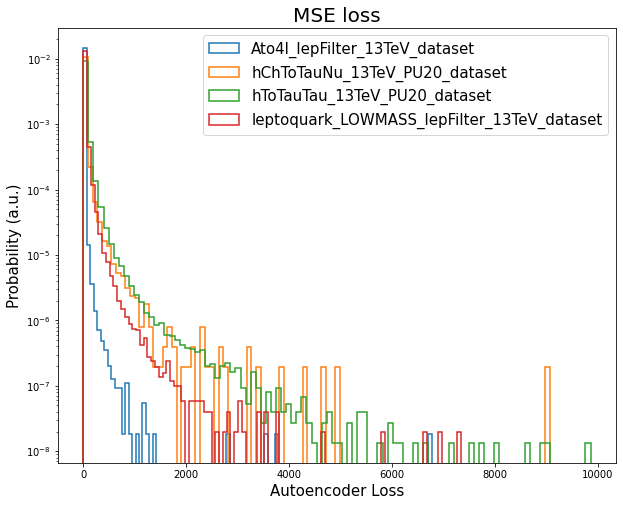

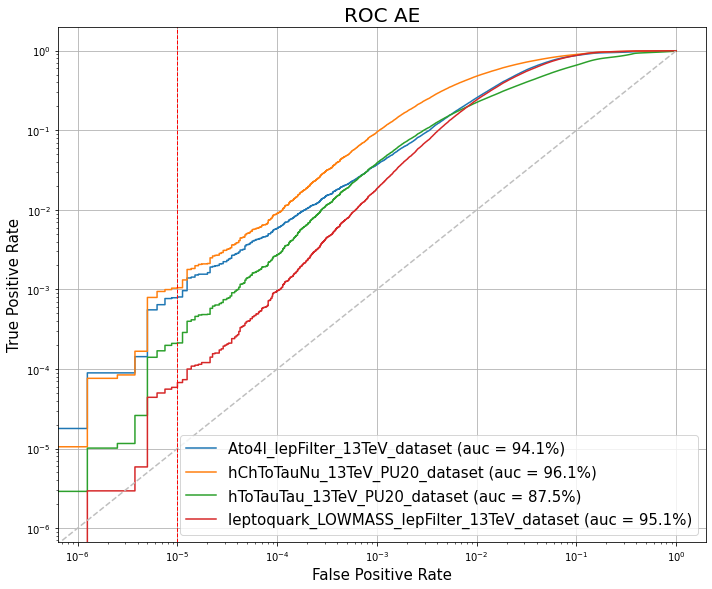

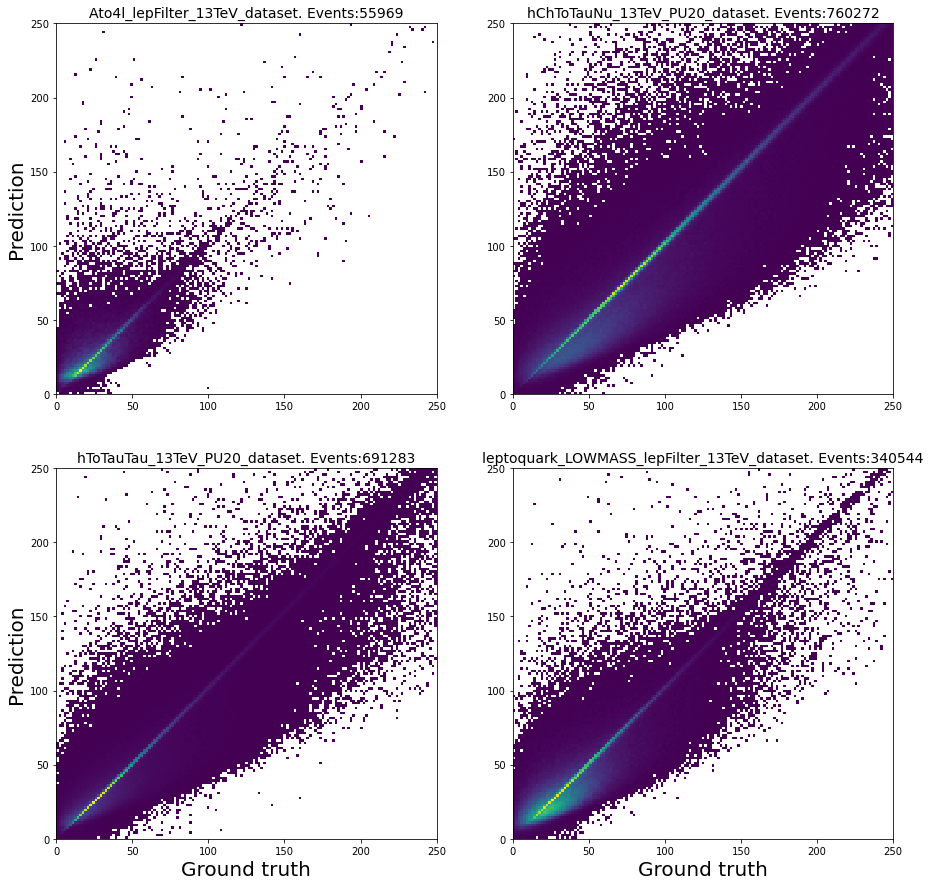

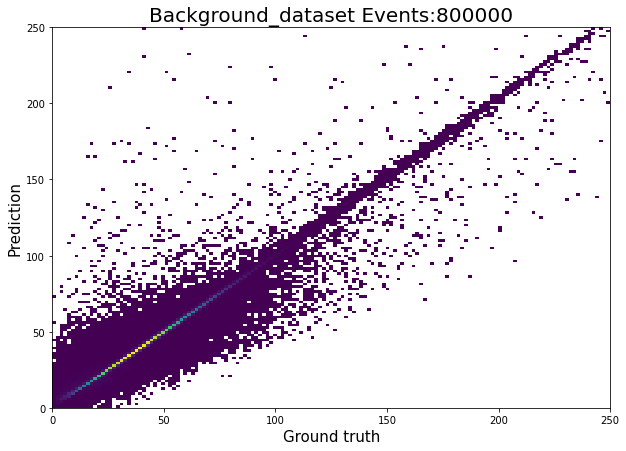

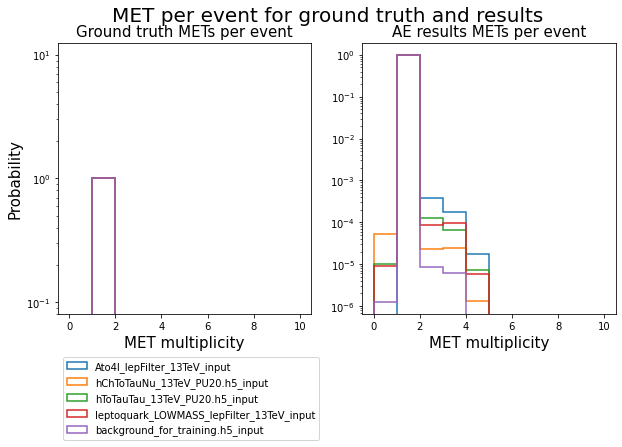

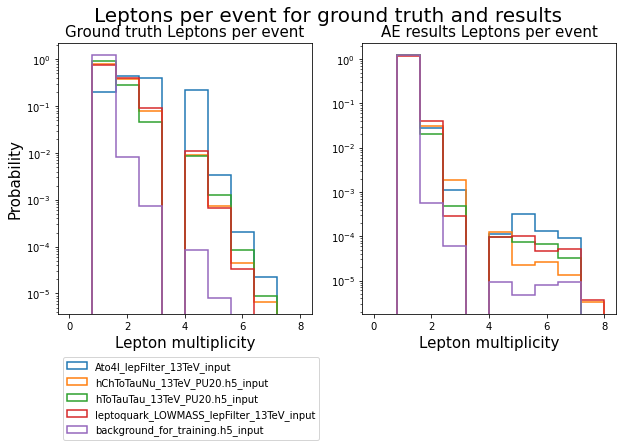

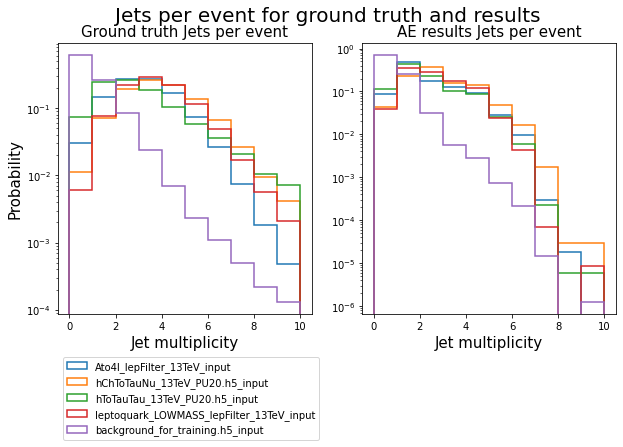

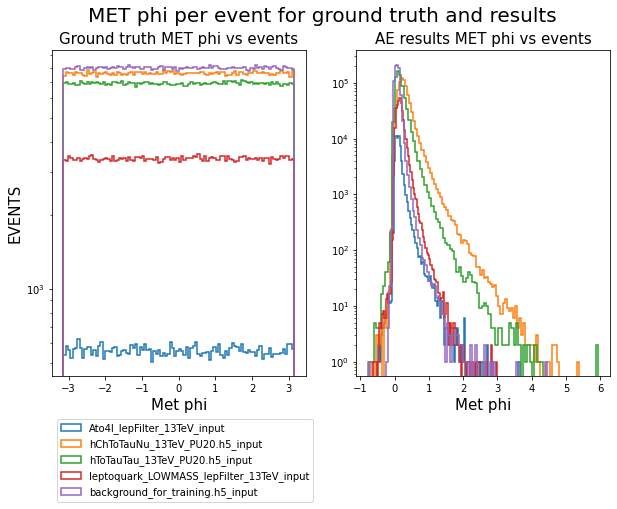

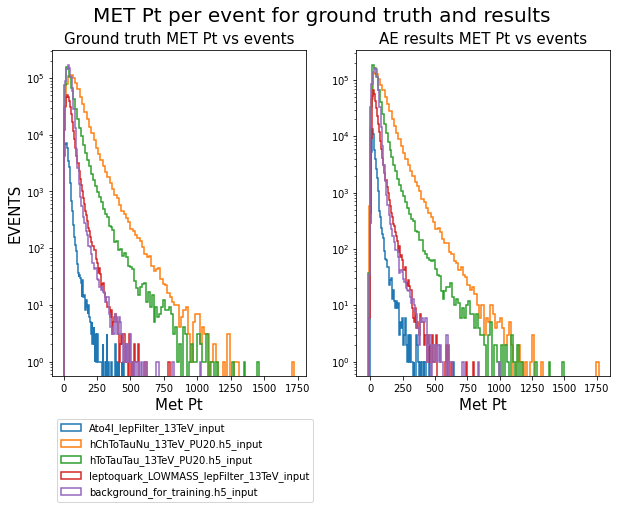

In [45]:
X_test,AE_OH_results,resh_type_results,ground_truth,signal_data=autoencoder("n",None,"n",None)

In [3]:
def read_bkg_and_signals(bkg_filename,signal_in):
    #Outputs training,test,validation and signal_data data
    #From assigned source/path
    # add correct path to signal files
    signals_file = [signal_in+'Ato4l_lepFilter_13TeV_input_OH_dataset.h5',
                signal_in+'hChToTauNu_13TeV_PU20_input_OH_dataset.h5',
                signal_in+'hToTauTau_13TeV_PU20_input_OH_dataset.h5',
                signal_in+'leptoquark_LOWMASS_lepFilter_13TeV_input_OH_dataset.h5'] 
    # add correct signal labels
    signal_labels = ['Ato4l_lepFilter_13TeV_dataset',
                     'hChToTauNu_13TeV_PU20_dataset',
                     'hToTauTau_13TeV_PU20_dataset',
                     'leptoquark_LOWMASS_lepFilter_13TeV_dataset']    
    with h5py.File(bkg_filename, 'r') as file:
        X_train = np.array(file['X_train'])
        X_test = np.array(file['X_test'])
        X_val = np.array(file['X_val'])
    signal_data = []
    for i, label in enumerate(signal_labels):
        with h5py.File(signals_file[i], 'r') as file:
            test_data = np.array(file['Data'])
        signal_data.append(test_data)
    
    return X_train,X_test,X_val,signal_data,signal_labels



In [4]:
def AE_setup_training(EPOCHS,BATCH_SIZE,X_train,X_test,X_val,signal_data,signal_labels):
    #Autoencoder(AE) model setup
    input_shape = 152
    latent_dimension = 3
    num_nodes=[16,8]
    
    #encoder
    inputArray = Input(shape=(input_shape))
    x = Dense(num_nodes[0], use_bias=False)(inputArray)
    x = Activation('relu')(x)
    x = Dense(latent_dimension, use_bias=False)(x)
    encoder = Activation('relu')(x)
    
    #decoder
    x = Dense(num_nodes[0], use_bias=False)(encoder)
    x = Activation('relu')(x)
    
    decoder = Dense(input_shape)(x)
    #Create AE
    autoencoder = Model(inputs = inputArray, outputs=decoder)
    autoencoder.summary()
    
    #Compile AE
    autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')
    print("flops:")
    # Compute FLOPs
    FLOPs = get_flops(autoencoder, batch_size=1)
    print("keras-flops: Total number of FLOPs = {} ".format(FLOPs))
   
    
    #Treenimine
    #EPOCHS = 10
    #BATCH_SIZE = 1024
    history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))
    return autoencoder,FLOPs

In [5]:
def predict_signal_bkg(signal_data,autoencoder,X_test):
    #Siia vist vaja panna inference aja võtmine ka
    AE_OH_results=[]
    for i in range(4):
        #All 4 signals predicted
        signal_prediction = autoencoder.predict(signal_data[i])
        AE_OH_results.append(np.array(signal_prediction))
    #Background prediction
    dummy=autoencoder.predict(X_test[:100])
    start = time.time()
    bkg_prediction = autoencoder.predict(X_test,batch_size=15000)
    end = time.time()
    inference_t=((end-start)/len(X_test))*10**6
    print(f'inference time per event: {inference_t} μs')
    AE_OH_results.append(np.array(bkg_prediction))
    
    return AE_OH_results,inference_t

In [6]:
from keras.models import model_from_json
def load_model(model_name, custom_objects=None):
    name = model_name + '.json'
    json_file = open(name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json, custom_objects=custom_objects)
    model.load_weights(model_name + '.h5')
    return model

def save_model(model_save_name, model):
    with open(model_save_name + '.json', 'w') as json_file:
        json_file.write(model.to_json())
    model.save_weights(model_save_name + '.h5')

In [7]:
def OH_reverse_convert(AE_OH_results,signal_data,X_test):
    resh_type_results=[]
    ground_truth=[]
    #Reshaping for autoencoder results
    for i in range(5):
        data=AE_OH_results[i]#take list  with bkg and signals  flattened output
        data=np.reshape(data,(len(data), 19,8))#reshape events by 19 objects
        id_oh=data[:,:,-5:]#take OH vector ids
        id_idmax=np.argmax(id_oh, axis=-1)#find the type
        id_idmax=np.reshape(id_idmax,(len(data),19,1))#reshape for concat
        event_wo_type=data[:,:,:3]#take events wo. type
        reshaped_data=np.concatenate([event_wo_type,id_idmax],axis=-1)#concat.
        resh_type_results.append(reshaped_data)#add to list
    #reshaping for ground truth in order to dataframe it correctly
    AE_OH_truth=signal_data
    AE_OH_truth.append(X_test)
    for i in range(5):
        data=AE_OH_truth[i]#take list  with bkg and signals  flattened output
        data=np.reshape(data,(len(data), 19,8))#reshape events by 19 objects
        id_oh=data[:,:,-5:]#take OH vector ids
        id_idmax=np.argmax(id_oh, axis=-1)#find the type
        id_idmax=np.reshape(id_idmax,(len(data),19,1))#reshape for concat
        event_wo_type=data[:,:,:3]#take events wo. type
        reshaped_data=np.concatenate([event_wo_type,id_idmax],axis=-1)#concat.
        ground_truth.append(reshaped_data)#add to list
    
    return ground_truth,resh_type_results

In [8]:
def find_attribute_multiplicities(ground_truth,resh_type_results):
    #function find multiplicities (JETS, LEPTONS, etc..) per event
    truth_attributes=[]
    results_attributes=[]
    attributes=[truth_attributes,results_attributes]
    
    # add correct signal labels
    data_labels  = ['Ato4l_lepFilter_13TeV_input',
                     'hChToTauNu_13TeV_PU20.h5_input',
                     'hToTauTau_13TeV_PU20.h5_input',
                     'leptoquark_LOWMASS_lepFilter_13TeV_input',
                     'background_for_training.h5_input']
    counter=0
    for n in range(2):
        if n==0:
            data=ground_truth
        else:
            data=resh_type_results
        for k, label in enumerate(data_labels):
            print("Finding lepton,jets etc.. multiplicities per event")
            counter += 1
            print(f'{counter}/10')
            MET=[]
            ELEKT=[]
            MUON=[]
            JETID=[]
            packed=[]
            for i in range(len(data[k])):
                ith_event=data[k][i][:,3]
                MET.append(np.count_nonzero(ith_event == 1))
                ELEKT.append(np.count_nonzero(ith_event == 2))
                MUON.append(np.count_nonzero(ith_event == 3))
                JETID.append(np.count_nonzero(ith_event == 4))

            packed.append(MET)
            packed.append(ELEKT)
            packed.append(MUON)
            packed.append(JETID)
            packed=np.asarray(packed)
            #print(packed)
            #print(packed.shape)
            attributes[n].append(packed)

    return attributes[0],attributes[1]

In [9]:
def dataframing(ground_truth,resh_type_results,truth_attributes,results_attributes):
    #Set up framing column names
    column_names=[]
    columns=['P_t','η','φ','type']
    objects=['MET','e/γ_1','e/γ_2','e/γ_3','e/γ_4','μ_1','μ_2','μ_3','μ_4','jet_1','jet_2','jet_3',
                       'jet_4','jet_5','jet_6','jet_7','jet_8','jet_9','jet_10']
    #MET
    for i in range(4):
        column_names.append(objects[0]+"_"+columns[i])
    #electron/photon
    for i in range(4):
        [column_names.append(objects[i+1]+"_"+columns[j]) for j in range(4)]
    #muons      
    for i in range(4):
        [column_names.append(objects[i+5]+"_"+columns[j]) for j in range(4)]
    #jets
    for i in range(10):
        [column_names.append(objects[i+9]+"_"+columns[j]) for j in range(4)]
    [column_names.append(["MET","ELEKT","MUON","JETS"][i]) for i in range(4)]
    #concatenate results and their attributes
    conced_truth=[]
    conced_results=[]
    for i in range(5):
        #shape(N-events,cardinality(19),attributes(4))
        reshaped=ground_truth[i].reshape(len(ground_truth[i]),76)#76=19*4
        conced=np.concatenate([reshaped,truth_attributes[i].T],axis=1)
        conced_truth.append(conced)
    for i in range(5):
        reshaped=resh_type_results[i].reshape(len(resh_type_results[i]),76)
        conced=np.concatenate([reshaped,results_attributes[i].T],axis=1)
        conced_results.append(conced)
    #Turn data into dataframes    
    truth_dfs=[]
    d={}
    for i in range(5):
        d["df_"+str(i)]=pd.DataFrame(conced_truth[i])#76+4 attributes
        d["df_"+str(i)].columns=column_names
        truth_dfs.append(d["df_"+str(i)])
    results_dfs=[]
    for i in range(5):
        d["df_"+str(i)]=pd.DataFrame(conced_results[i])
        d["df_"+str(i)].columns=column_names
        results_dfs.append(d["df_"+str(i)]) 
    
    return truth_dfs,results_dfs

In [44]:
def plotting(truth_dfs,results_dfs,signal_labels,s_plots_path,save_plots,inference_t,FLOPs):
    
    if save_plots == "y":
        date= datetime.now().strftime("_%d_%m")
        plot_name = input("Enter plots name(date is added automatically): ")
        plot_name = plot_name+date
        
        #save FLOPS and latency to txt file
        f= open(s_plots_path+plot_name+"_lat_FLOPs.txt","w+")
        f.write(f'Latency: {inference_t} microseconds \n')
        f.write(f'FLOPs: {FLOPs}')
        f.close()
    data_labels  = ['Ato4l_lepFilter_13TeV_input',
                 'hChToTauNu_13TeV_PU20.h5_input',
                 'hToTauTau_13TeV_PU20.h5_input',
                 'leptoquark_LOWMASS_lepFilter_13TeV_input',
                 'background_for_training.h5_input']
    
    
    #MSE loss plotting
    #compute loss value (true, predicted)##1 väljund ja plot roc nr 3.
    total_loss = []
    total_loss.append(mse_loss(truth_dfs[4], results_dfs[4]).numpy())
    for i, signal_X in enumerate(truth_dfs[:4]):
        total_loss.append(mse_loss(signal_X, results_dfs[i]).numpy())
            
    #bin_size=np.linspace(0, 10000, 100)
    bin_size=100
    
    plt.figure(figsize=(10,8))
    for i, label in enumerate(signal_labels):
        plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
    plt.yscale('log')
    plt.xlabel("Autoencoder Loss",fontsize=15)
    plt.ylabel("Probability (a.u.)",fontsize=15)
    plt.title('MSE loss',fontsize=20)
    plt.legend(loc='best',fontsize=15)
    if save_plots == "n":
        pass
    else:
        plt.savefig(s_plots_path+plot_name+"_MSE.png")
        
    #Roc Curve plotting
    labels = np.concatenate([['Background'], np.array(signal_labels)])
    target_background = np.zeros(total_loss[0].shape[0])
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        if i == 0: continue # background events
        trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
        predVal_loss = np.concatenate((total_loss[i], total_loss[0]))
        fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
        auc_loss = auc(fpr_loss, tpr_loss)
        plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
        plt.semilogx()
        plt.semilogy()
        plt.ylabel("True Positive Rate",fontsize=15)
        plt.xlabel("False Positive Rate",fontsize=15)
        plt.legend(loc=4,fontsize=15)
        plt.grid(True)
        plt.tight_layout()
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
    plt.title("ROC AE",fontsize=20)
    if save_plots == "n":
        pass
    else:
        plt.savefig(s_plots_path+plot_name+"_ROC.png",bbox_inches="tight")
        
        
    
    #2d histogramm plotting
    
    bins=np.linspace(0,250,num=150)
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
    #signal plotting
    for ax,i in zip(axes.flat[0:],[0,1,2,3]):
        ax
        ax.set_title(signal_labels[i]+'. Events:{0}'.format(len(truth_dfs[i])),fontsize=14)
        ax.hist2d(truth_dfs[i]["MET_P_t"],results_dfs[i]["MET_P_t"],bins=bins,label=label,cmin=1)
        if i == 0 or i==2:
            ax.set_ylabel('Prediction',fontsize=20)
        if i == 2 or i ==3:   
            ax.set_xlabel('Ground truth',fontsize=20)
    if save_plots == "n":
        pass
    else:
        plt.savefig(s_plots_path+plot_name+"_signal.png")
    #background plotting
    fig, ax = plt.subplots(figsize =(10, 7))
    matplotlib.pyplot.hist2d(truth_dfs[4]["MET_P_t"],results_dfs[4]["MET_P_t"],bins=bins,cmin=1)
    ax.set_title('Background_dataset'+' Events:{0}'.format(len(truth_dfs[4])),fontsize=20)
    ax.set_ylabel('Prediction',fontsize=15)
    ax.set_xlabel('Ground truth',fontsize=15)
    if save_plots == "n":
        pass
    else:
        plt.savefig(s_plots_path+plot_name+"_bkg.png")
        
    #Plotting MET per event for ground truth and AE results
    bins = np.linspace(0, 10, 11)
    plt.figure(figsize=(10,5))
    plt.suptitle('MET per event for ground truth and results',fontsize=20)
    for n in range(2):
        if n == 0:
            data=truth_dfs
            string="Ground truth "
        else:
            data=results_dfs 
            string="AE results "
            
        plt.subplot(1, 2, n+1)
        for i, label in enumerate(data_labels):
            plt.hist(data[i]["MET"], bins=bins, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
        plt.yscale('log')
        plt.xlabel("MET multiplicity",fontsize=15)
        if n == 0:
            plt.ylabel("Probability",fontsize=15)
            
        plt.title(string+'METs per event',fontsize=15)
        if n == 0:
            plt.legend(bbox_to_anchor=(0,-0.48), loc="lower left")
    if save_plots == "n":
        pass
    else:
        plt.savefig(s_plots_path+plot_name+"_MET_mult.png")
        
    #Plotting N leptons per event for ground truth and AE results    
    bins = np.linspace(0, 8, 11)
    plt.figure(figsize=(10,5))
    plt.suptitle('Leptons per event for ground truth and results',fontsize=20)
    for n in range(2):
        if n == 0:
            data=truth_dfs
            string="Ground truth "
        else:
            data=results_dfs 
            string="AE results "
            
        plt.subplot(1, 2, n+1)
        for i, label in enumerate(data_labels):
            plt.hist(data[i]["ELEKT"]+data[i]["MUON"], bins=bins, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
        plt.yscale('log')
        plt.xlabel("Lepton multiplicity",fontsize=15)
        if n== 0:
            plt.ylabel("Probability",fontsize=15)
        plt.title(string+'Leptons per event',fontsize=15)
        if n == 0:
            plt.legend(bbox_to_anchor=(0,-0.48), loc="lower left")
    if save_plots == "n":
        pass
    else:
        plt.savefig(s_plots_path+plot_name+"_LEP_mult.png")       
    
    #Jets per event for gorund truth and AE results
    bins = np.linspace(0,10, 11)
    plt.figure(figsize=(10,5))
    plt.suptitle('Jets per event for ground truth and results',fontsize=20)
    for n in range(2):
        if n == 0:
            data=truth_dfs
            string="Ground truth "
        else:
            data=results_dfs 
            string="AE results "
            
        plt.subplot(1, 2, n+1)
        for i, label in enumerate(data_labels):
            plt.hist(data[i]["JETS"], bins=bins, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
        plt.yscale('log')
        plt.xlabel("Jet multiplicity",fontsize=15)
        if n == 0:
            plt.ylabel("Probability",fontsize=15)
        plt.title(string+'Jets per event',fontsize=15)
        if n == 0:
            plt.legend(bbox_to_anchor=(0,-0.48), loc="lower left")
    if save_plots == "n":
        pass
    else:
        plt.savefig(s_plots_path+plot_name+"_JETS_mult.png")  
    
    #Plot MET vs phi per event for ground truth and AE results
    bin_size=100
    #bins = np.linspace(0,10, 11)
    plt.figure(figsize=(10,6))
    plt.suptitle('MET phi per event for ground truth and results',fontsize=20)
    for n in range(2):
        if n == 0:
            data=truth_dfs
            string="Ground truth "
        else:
            data=results_dfs 
            string="AE results "   
        plt.subplot(1, 2, n+1)
        for i, label in enumerate(data_labels):
            plt.hist(data[i]["MET_φ"],bins=bin_size, label=label, histtype='step', fill=False, linewidth=1.5,log=True)
        plt.yscale('log')
        plt.xlabel("Met phi",fontsize=15)
        if n== 0:
            plt.ylabel("EVENTS",fontsize=15)
        plt.title(string+'MET phi vs events',fontsize=15)
        if n == 0:
            plt.legend(bbox_to_anchor=(0,-0.4), loc="lower left")
    if save_plots == "n":
        pass
    else:
        plt.savefig(s_plots_path+plot_name+"_MET_phi.png")  

    #Plot MET vs phi per event for ground truth and AE results
    bin_size=100
    plt.figure(figsize=(10,6))
    plt.suptitle('MET Pt per event for ground truth and results',fontsize=20)
    for n in range(2):
        if n == 0:
            data=truth_dfs
            string="Ground truth "
        else:
            data=results_dfs 
            string="AE results "
        plt.subplot(1, 2, n+1)
        for i, label in enumerate(data_labels):
            plt.hist(data[i]["MET_P_t"],bins=bin_size, label=label, histtype='step', fill=False, linewidth=1.5,log=True)
        plt.yscale('log')
        plt.xlabel("Met Pt",fontsize=15)
        if n == 0:
            plt.ylabel("EVENTS",fontsize=15)
        plt.title(string+"MET Pt vs events",fontsize=15)
        if n == 0:
            plt.legend(bbox_to_anchor=(0,-0.4), loc="lower left")
    if save_plots == "n":
        pass
    else:
        plt.savefig(s_plots_path+plot_name+"_MET_Pt.png")
        
        

In [172]:
truth_dfs[0]

,MET_P_t,MET_η,MET_φ,MET_type,e/γ_1_P_t,e/γ_1_η,e/γ_1_φ,e/γ_1_type,e/γ_2_P_t,e/γ_2_η,...,jet_9_φ,jet_9_type,jet_10_P_t,jet_10_η,jet_10_φ,jet_10_type,MET,ELEKT,MUON,JETS
0,33.110535,0.0,-0.748136,1.0,35.706711,-1.159254,-3.048645,2.0,10.235106,-1.092886,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0
1,51.775829,0.0,1.001453,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,26.158934,0.0,0.881233,1.0,31.266123,-0.441200,2.021050,2.0,9.198785,-1.120467,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,3.0
3,18.437334,0.0,-2.664090,1.0,30.535053,2.314868,0.683920,2.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0
4,18.074430,0.0,-2.150683,1.0,23.317005,-1.984133,-2.058434,2.0,6.156993,-1.996701,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55964,41.243225,0.0,2.314595,1.0,24.052776,0.047231,-0.519232,2.0,14.379307,0.274302,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,2.0
55965,17.217930,0.0,-1.715467,1.0,19.076210,-2.195431,1.551366,2.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0
55966,15.010694,0.0,3.140705,1.0,35.804859,-2.427578,0.411938,2.0,26.680445,-2.648414,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0
55967,11.389110,0.0,2.404446,1.0,29.798540,0.702813,1.263565,2.0,17.898071,0.183132,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,3.0


In [91]:
df_2=pd.DataFrame(ground_truth[0][0])
df_3=pd.DataFrame(resh_type_results[0][0])
df_2.columns=['P_t','η','φ','type']
df_3.columns=['P_t','η','φ','type']
df_2.index=['MET','e/γ_1','e/γ_2','e/γ_3','e/γ_4','μ_1','μ_2','μ_3','μ_4','jet_1','jet_2','jet_3',
                      'jet_4','jet_5','jet_6','jet_7','jet_8','jet_9','jet_10']
df_3.index=['MET','e/γ_1','e/γ_2','e/γ_3','e/γ_4','μ_1','μ_2','μ_3','μ_4','jet_1','jet_2','jet_3',
                      'jet_4','jet_5','jet_6','jet_7','jet_8','jet_9','jet_10']
df_2

,P_t,η,φ,type
MET,33.110535,0.000000,-0.748136,1.0
e/γ_1,35.706711,-1.159254,-3.048645,2.0
e/γ_2,10.235106,-1.092886,0.858731,2.0
e/γ_3,0.000000,0.000000,0.000000,0.0
e/γ_4,0.000000,0.000000,0.000000,0.0
μ_1,16.219484,-1.687153,2.607409,3.0
μ_2,5.202247,-1.327719,-2.166493,3.0
μ_3,0.000000,0.000000,0.000000,0.0
μ_4,0.000000,0.000000,0.000000,0.0
jet_1,40.693729,-1.181976,-3.047491,4.0


In [32]:
path="./plots/"

In [33]:
date='25_03_22'
name='speed'
time=0.72
flops=2393
f= open(path+date+'_'+name+"_perf.txt","w+")
f.write(f'Latency: {time} microseconds \n')
f.write(f'FLOPs: {flops}')
f.close()